In [1]:
import sys
sys.path.append("..")
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
from src.spectra import sensor_spectra
from src.bulk_parameters import Hs_band, compute_H0
from src.statistics import bin_stats, plot_chisq_landscape
from src.model_fit import fit_model, plot_model



# 1. Scaling of Wave Setup

**Theory:** Use buckingham pi non-dimensional scaling to understand the $H_0^{1.75}L_0^{0.75}$ scaling. 

**Analytical Plan:**
- partition into discrete tidal bins (Low, mid, high)
- perform linear/nonlinear regression for each bin seperately
- try $\bar{\eta} = K * H_0^a*L_0^b*h_r^c$

**Deliverables:**
- Fig 1. Setup ($\bar{\eta}/H_0$) vs reef flat depth ($h_r$)
- Fig 2. test dependence on wave period
	- X: $H_0L_0$
	- Y: $\bar{\eta}/H_0$
- Fig 3. Setup vs Scaling Parameter
	- $\bar{\eta} = K * H_0^a*L_0^b*h_r^c$
	- or could be $\Pi = H_0^ah_r^c$   
    

In [2]:
## Dataframe set up 

# load prior bulk_df
bulk_df = pd.read_parquet('../data_interim/bulk_df.parquet')

# Range of tide is from -0.47m to 0.51m
# defining "low tide" as <0 and high tide as >0
tide_df = bulk_df.copy()
tide_df['Tide_lo'] = tide_df['h_tide'] < 0
tide_df['Tide_hi'] = tide_df['h_tide'] > 0

# split dataframe into lo and hi tide
df_lo = tide_df[tide_df['Tide_lo'] == True].copy()
df_hi = tide_df[tide_df['Tide_hi'] == True].copy()


In [3]:
# bin data
bin_col='H0'
agg_cols=['H0', 'L0', 'n', 'H0L0', 'steepness', 'setup'] 
binned_lo = bin_stats(df_lo, bin_col=bin_col, agg_cols=agg_cols, bin_size=0.1)
binned_hi = bin_stats(df_hi, bin_col=bin_col, agg_cols=agg_cols, bin_size=0.1)

# model fit
def monismith_offset(X, a, b, c, d):
    H0, L0 = X
    return a * (H0**b) * (L0**c) + d

res_lo = fit_model(
    model_func=monismith_offset,
    binned_df=binned_lo,
    x_cols=['H0_mean', 'L0_mean'], 
    p0=[0.1, -2.0, 0.0, -0.15],
    bounds=([0, -5, -5, -0.5], [np.inf, 5, 5, 0.5]),
    label="Monismith Fit"
)
res_hi = fit_model(
    model_func=monismith_offset,
    binned_df=binned_hi,
    x_cols=['H0_mean', 'L0_mean'], 
    p0=[0.1, -2.0, 0.0, -0.15],
    bounds=([0, -5, -5, -0.5], [np.inf, 5, 5, 0.5]),
    label="Monismith Fit"
)


--- Monismith Fit ---
Params: [ 0.0019  1.7081  0.6599 -0.1105]
RMSE: 0.0314 m | Chi^2: 1.47

--- Monismith Fit ---
Params: [ 8.0000e-04  1.6821e+00  8.2470e-01 -1.1170e-01]
RMSE: 0.0480 m | Chi^2: 2.44



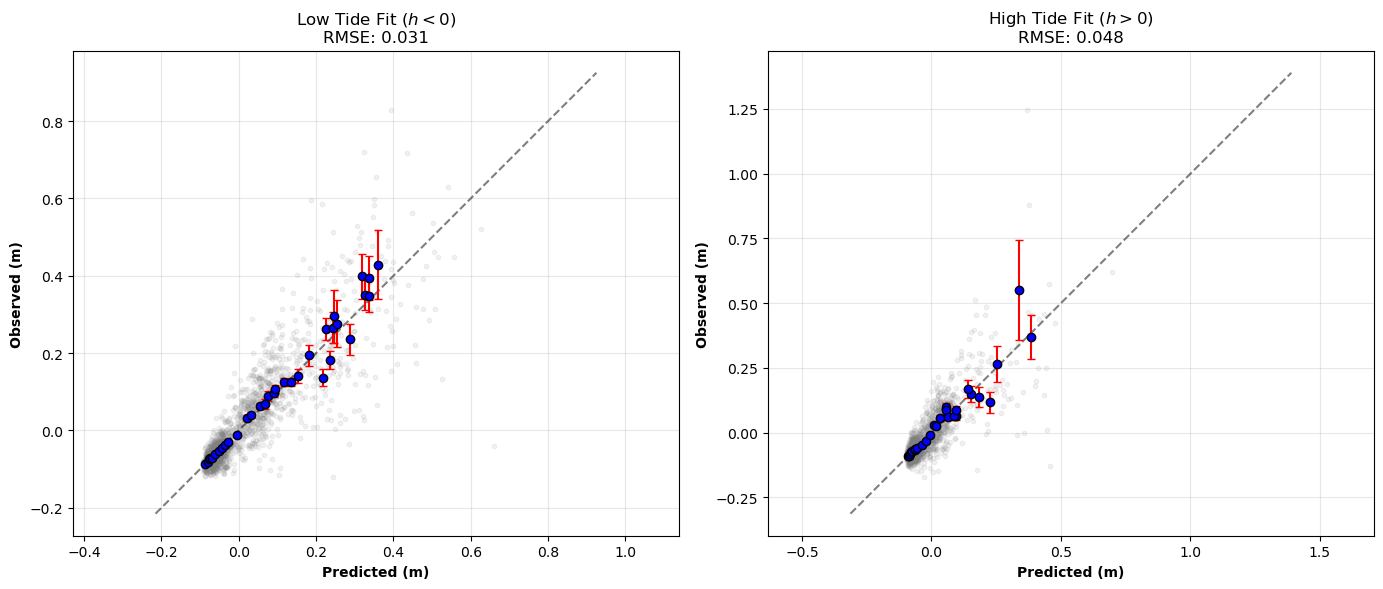

In [4]:
# --- 1. VISUALIZE RES_LO and RES_HI ---
# We disable sharex/sharey to avoid the "adjustable='datalim'" RuntimeError
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=False, sharey=False)

# --- Plot Low Tide ---
if res_lo:
    plot_model(res_lo, binned_lo, df_lo, ['H0', 'L0'], 'n', ax=axes[0])
    # Extract params for title
    p = res_lo['popt']
    axes[0].set_title(f"Low Tide Fit ($h < 0$)\nRMSE: {res_lo['rmse']:.3f}")
else:
    axes[0].text(0.5, 0.5, "Fit Failed", ha='center')

# --- Plot High Tide ---
if res_hi:
    plot_model(res_hi, binned_hi, df_hi, ['H0', 'L0'], 'n', ax=axes[1])
    p = res_hi['popt']
    axes[1].set_title(f"High Tide Fit ($h > 0$)\nRMSE: {res_hi['rmse']:.3f}")
else:
    axes[1].text(0.5, 0.5, "Fit Failed", ha='center')

plt.tight_layout()
plt.show()

--- LOW TIDE LANDSCAPE ---
Scanning exponent grid (Weighted)...


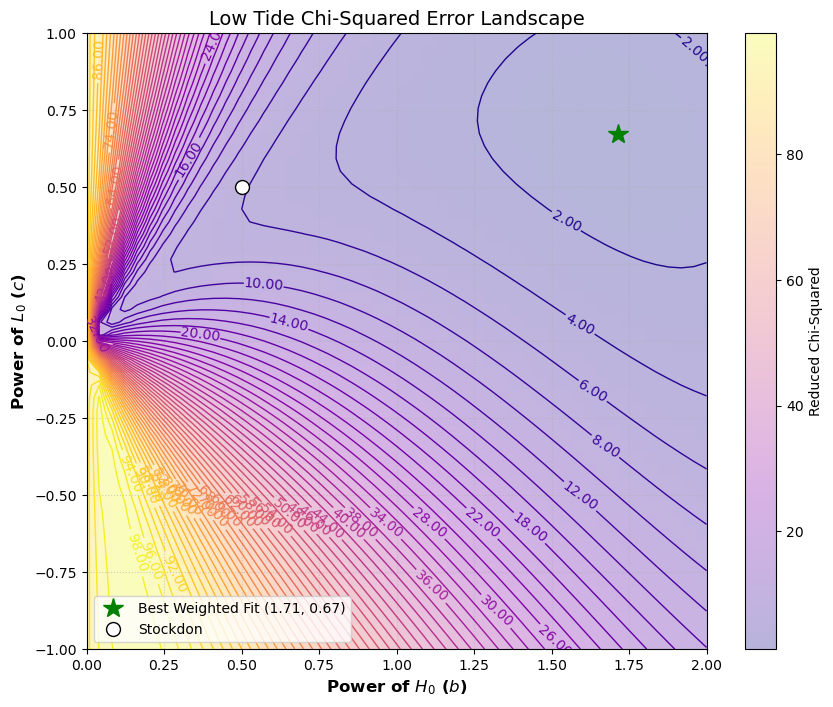

Low Tide Optimal: H0^1.71 * L0^0.67


In [5]:
print("--- LOW TIDE LANDSCAPE ---")
best_b_lo, best_c_lo = plot_chisq_landscape(
    binned_lo,            # Your Low Tide binned data
    h_col='H0_mean',      # The binned H0 column
    l_col='L0_mean',      # The binned L0 column
    y_col='setup_mean',       # The binned Setup column
    sigma_col='setup_sem',    # The calculated standard error
    # You can adjust ranges if the best fit hits the edge
    b_range=np.linspace(0, 2.0, 50), 
    c_range=np.linspace(-1.0, 1.0, 50), 
    levels=60,
    title = 'Low Tide Chi-Squared Error Landscape'

)
print(f"Low Tide Optimal: H0^{best_b_lo:.2f} * L0^{best_c_lo:.2f}")


--- HIGH TIDE LANDSCAPE ---
Scanning exponent grid (Weighted)...


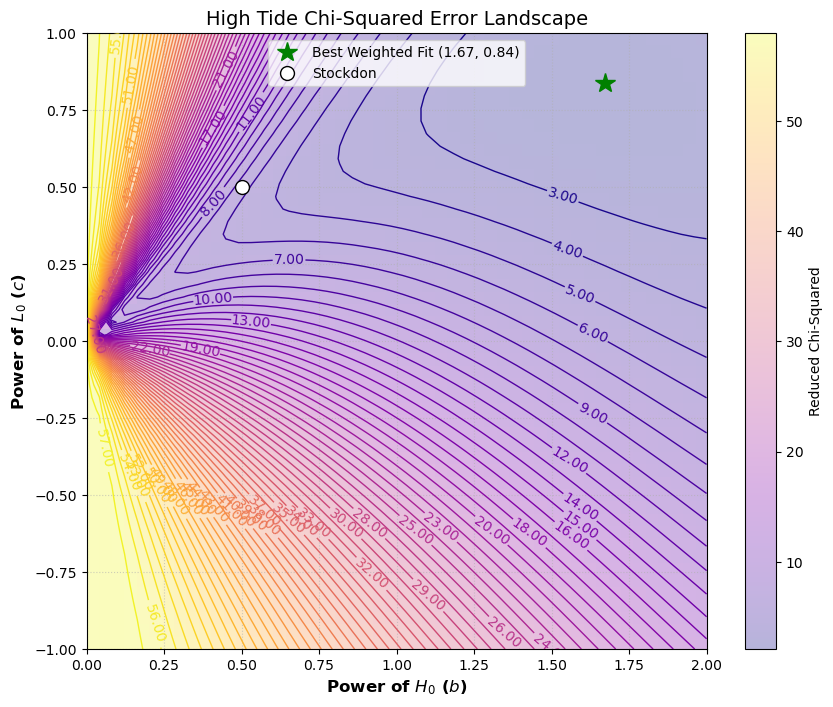

High Tide Optimal: H0^1.67 * L0^0.84


In [6]:
print("\n--- HIGH TIDE LANDSCAPE ---")
best_b_hi, best_c_hi = plot_chisq_landscape(
    binned_hi,            # Your High Tide binned data
    h_col='H0_mean', 
    l_col='L0_mean', 
    y_col='n_mean',
    sigma_col='n_sem',
    b_range=np.linspace(0, 2.0, 50),
    c_range=np.linspace(-1.0, 1.0, 50),
    levels=60, 
    title = 'High Tide Chi-Squared Error Landscape'
)

print(f"High Tide Optimal: H0^{best_b_hi:.2f} * L0^{best_c_hi:.2f}")

No real remarkable difference between high/low tide. Im going to add an h factor, the reef flat depth sicne we already know setup is related to tide modulations. 

#### Adjusting nonlinear model 


$\bar{\eta} = K * H_0^a*L_0^b*h_r^c$

In [7]:
bulk_df

,H0,n,h_tide,L0,H0/L0,H0L0,steepness,Tp,Hs_IG_Nearshore,setdown_x,setup,H6,setdown_y,setdown
time,,,,,,,,,,,,,,
2007-12-14 12:15:01.003921408,1.645071,-0.029936,0.173463,91.624145,0.017955,150.728218,0.017955,14.634210,0.196278,-8.612608e-08,-0.029936,1.786121,-8.612608e-08,-8.612608e-08
2007-12-14 12:30:01.007838208,1.626725,-0.078732,0.197391,82.591279,0.019696,134.353266,0.019696,13.846214,0.209341,-6.321125e-08,-0.078732,1.726074,-6.321125e-08,-6.321125e-08
2007-12-14 12:45:01.011755007,1.635449,-0.077717,0.220038,88.654160,0.018448,144.989335,0.018448,14.173290,0.210029,-6.381081e-08,-0.077717,1.752083,-6.381081e-08,-6.381081e-08
2007-12-14 13:00:01.015671808,1.512499,-0.017358,0.241270,76.812256,0.019691,116.178469,0.019691,13.333391,0.205247,-9.041383e-08,-0.017358,1.579092,-9.041383e-08,-9.041383e-08
2007-12-14 13:15:01.019588608,1.383515,-0.035062,0.260961,69.346901,0.019951,95.942475,0.019951,13.740518,0.168462,-8.536625e-08,-0.035062,1.463238,-8.536625e-08,-8.536625e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-01-17 22:15:13.945028607,1.636291,0.074588,-0.382151,140.963989,0.011608,230.658171,0.011608,12.676112,0.256726,-7.538904e-08,0.074588,1.705907,-7.538904e-08,-7.538904e-08
2008-01-17 22:30:13.948945407,1.836326,0.065204,-0.398928,136.162355,0.013486,250.038532,0.013486,13.333391,0.227943,-7.189168e-08,0.065204,1.926385,-7.189168e-08,-7.189168e-08
2008-01-17 22:45:13.952862207,1.638650,0.045569,-0.414873,128.485516,0.012754,210.542782,0.012754,12.949697,0.248969,-7.355116e-08,0.045569,1.709467,-7.355116e-08,-7.355116e-08


In [8]:
# add reef flat depth to the bulk_df
# using sensor 1 as reef flat depth 
df1 = pd.read_parquet('../data_interim/df1.parquet')

h_reef = df1['h'].sort_index().rename('h_reef')

# # 2. Perform the merge
# # We use direction='nearest' to find the closest sensor reading
bulk_df = pd.merge_asof(
    bulk_df,
    h_reef,
    left_index=True,
    right_index=True,
    direction='nearest',
    tolerance=pd.Timedelta(minutes=30)
)
# bin data
bin_col='H0'
agg_cols=['H0', 'L0', 'n', 'H0L0', 'steepness', 'setup', 'h_reef'] 
binned_h = bin_stats(bulk_df, bin_col=bin_col, agg_cols=agg_cols, bin_size=0.1)

# save binned dataframe with depth
binned_h.to_parquet('binned_df.parquet')


In [ ]:
# model fit
def monismith_offset(X, a, b, c, d):
    H0, L0 = X
    return a * (H0**b) * (L0**c) + d

res_lo = fit_model(
    model_func=monismith_offset,
    binned_df=binned_lo,
    x_cols=['H0_mean', 'L0_mean'], 
    p0=[0.1, -2.0, 0.0, -0.15],
    bounds=([0, -5, -5, -0.5], [np.inf, 5, 5, 0.5]),
    label="Monismith Fit")

SyntaxError: incomplete input (2324832226.py, line 12)

In [17]:
def depth_lim(X, a, b, c, d, e):
    H0,L0,h = X
    return a * (H0**b) * (L0**c) * (h**d) + e

res_reef_depth = fit_model(
    model_func=depth_lim,
    binned_df = binned_h,
    x_cols=['H0_mean', 'L0_mean', 'h_reef_mean'],
    p0=[0.1,-2.0,0.0,-0.5,-0.15],
    bounds=([0,-5,-5,-5,-0.5], [np.inf,5,5,0.5, 0.5]),
    label="Depth Limited Fit"
)

# Extract from your dictionary
popt = res_reef_depth['popt']
a, b, c, d, e = popt

# Print the formatted equation
equation = (
    f"Setup = {a:.4e} * (H0^{b:.2f}) * (L0^{c:.2f}) * (h_reef^{d:.2f}) + ({e:.2f})"
)

print("--- Fitted Equation ---")
print(equation)

--- Depth Limited Fit ---
Params: [ 1.1000e-03  1.7856e+00  7.7040e-01 -3.5210e-01 -1.0920e-01]
RMSE: 0.0372 m | Chi^2: 2.35

--- Fitted Equation ---
Setup = 1.1251e-03 * (H0^1.79) * (L0^0.77) * (h_reef^-0.35) + (-0.11)


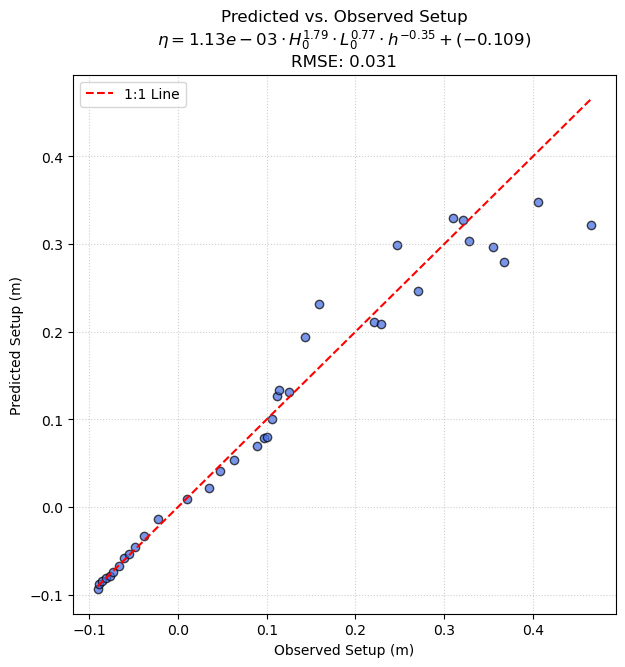

In [24]:
# 1. Extract params
a, b, c, d, e = res_reef_depth['popt']

# 2. Build the LaTeX equation string for the title
# We use r"..." (raw string) so LaTeX backslashes don't cause errors
eq_title = (
    rf"$\eta = {a:.2e} \cdot H_0^{{{b:.2f}}} \cdot L_0^{{{c:.2f}}} \cdot h^{{{d:.2f}}} + ({e:.3f})$"
)

# 3. Plotting
observed = binned_h['setup_mean']
predicted = res_reef_depth['y_pred_binned']

plt.figure(figsize=(7, 7))
plt.scatter(observed, predicted, color='royalblue', alpha=0.7, edgecolors='k')

# 1:1 Reference Line
line_min, line_max = observed.min(), observed.max()
plt.plot([line_min, line_max], [line_min, line_max], 'r--', label='1:1 Line')

# 4. Add the Equation to the Title
# We use a newline \n to keep the title from getting too cramped
plt.title(f"Predicted vs. Observed Setup\n{eq_title} \nRMSE: {res_lo['rmse']:.3f}", fontsize=12)


plt.xlabel("Observed Setup (m)")
plt.ylabel("Predicted Setup (m)")
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()
plt.show()

$ \eta \propto \frac{H_0^{1.79} * L_0^{0.77}}{h_{reef}^{0.35}}$

In [25]:
def get_rmse_landscape(d_val, e_val, popt, binned_df):
    # Fix a from your previous fit, and use your preferred b and c
    a = popt[0] 
    b, c = 1.75, 0.75
    
    H0 = binned_df['H0_mean']
    L0 = binned_df['L0_mean']
    h = binned_df['h_reef_mean']
    observed = binned_df['setup_mean']
    
    # Calculate model with test d and e
    pred = a * (H0**b) * (L0**c) * (h**d_val) + e_val
    
    # Return RMSE
    return np.sqrt(np.mean((observed - pred)**2))

Scanning h_reef exponent grid (Fixed b=1.75, c=0.75)...


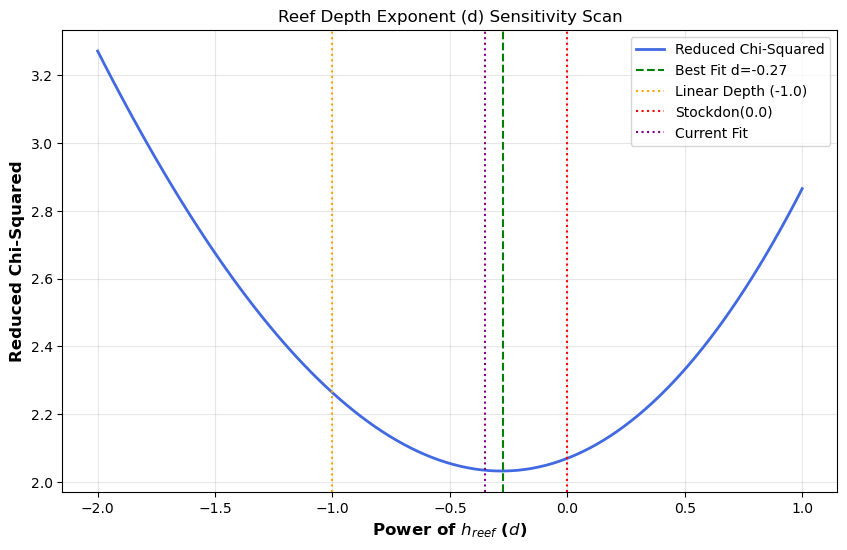

The theoretically optimal power for h_reef is: -0.273


In [29]:
def plot_depth_theory_landscape(binned_df, 
                                d_range=np.linspace(-2.0, 0.5, 50), 
                                fixed_b=1.75, 
                                fixed_c=0.75,
                                title='Reef Depth Coefficient Sensitivity'):
    """
    Scans the exponent of h_reef (d) to see how it affects the fit quality.
    """
    # Extract data
    H = binned_df['H0_mean'].values
    L = binned_df['L0_mean'].values
    h = binned_df['h_reef_mean'].values
    Y = binned_df['setup_mean'].values
    Sigma = binned_df['setup_sem'].values # Ensure you have a SEM or Std column
    
    weights = 1.0 / Sigma 
    
    # We are scanning 1D (just d), but to keep the 'landscape' feel, 
    # we can plot Chi-Squared vs. d. 
    # If you want a 2D plot, we can scan d vs. a (Lead Coeff).
    
    d_results = []
    chi_results = []
    
    print(f"Scanning h_reef exponent grid (Fixed b={fixed_b}, c={fixed_c})...")
    
    for d_val in d_range:
        # Z is our combined term: (H^b * L^c * h^d)
        Z = (H**fixed_b) * (L**fixed_c) * (h**d_val)
        
        try:
            # Linear fit: Y = a*Z + e
            # coeffs[0] is 'a', coeffs[1] is 'e'
            coeffs = np.polyfit(Z, Y, 1, w=weights)
            p = np.poly1d(coeffs)
            Y_pred = p(Z)
            
            chi_sq = np.sum(((Y - Y_pred) / Sigma)**2)
            chi_results.append(chi_sq / len(Y))
            d_results.append(d_val)
        except:
            continue

    # --- PLOTTING ---
    plt.figure(figsize=(10, 6))
    plt.plot(d_results, chi_results, color='royalblue', lw=2, label='Reduced Chi-Squared')
    
    # Find Minimum
    best_d = d_results[np.argmin(chi_results)]
    plt.axvline(best_d, color='g', linestyle='--', label=f'Best Fit d={best_d:.2f}')
    
    # Add theoretical markers (Common in Reef Literature)
    theory_points = {
        'Linear Depth (-1.0)': -1.0,
        'Stockdon(0.0)': 0.0,
        'Current Fit': res_reef_depth['popt'][3]
    }
    
    colors = ['orange', 'red', 'purple']
    for (label, val), col in zip(theory_points.items(), colors):
        plt.axvline(val, color=col, linestyle=':', label=label)

    plt.xlabel('Power of $h_{reef}$ ($d$)', fontsize=12, fontweight='bold')
    plt.ylabel('Reduced Chi-Squared', fontsize=12, fontweight='bold')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    return best_d

# 1. Define the range of 'd' (power of h_reef) you want to explore
# Usually reef depth powers range from -2.0 (strong effect) to 0.5
d_test_range = np.linspace(-2.0, 1.0, 100)

# 2. Run the function
# Note: Ensure 'setup_sem' exists in your binned_h (or use 'setup_std')
best_d = plot_depth_theory_landscape(
    binned_df=binned_h, 
    d_range=d_test_range,
    fixed_b=1.75,   # Fixing H0 power based on your preference
    fixed_c=0.75,   # Fixing L0 power based on your preference
    title='Reef Depth Exponent (d) Sensitivity Scan'
)

print(f"The theoretically optimal power for h_reef is: {best_d:.3f}")

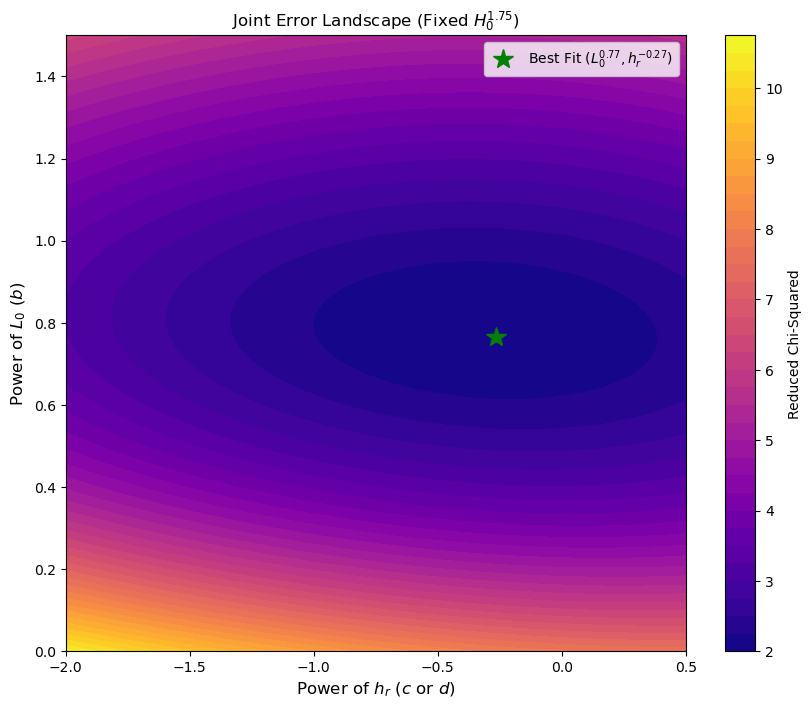

In [30]:
def plot_joint_landscape(binned_df, 
                         l_range=np.linspace(0, 1.5, 50), # power 'c'
                         h_range=np.linspace(-2.0, 0.5, 50), # power 'd'
                         fixed_b=1.75):
    
    H = binned_df['H0_mean'].values
    L = binned_df['L0_mean'].values
    hr = binned_df['h_reef_mean'].values
    Y = binned_df['setup_mean'].values
    Sigma = binned_df['setup_sem'].values
    weights = 1.0 / Sigma 

    chi_grid = np.zeros((len(l_range), len(h_range)))

    for i, l_pow in enumerate(l_range):
        for j, h_pow in enumerate(h_range):
            # The scaling term: H^1.75 * L^l_pow * hr^h_pow
            Z = (H**fixed_b) * (L**l_pow) * (hr**h_pow)
            
            # Linear regression: Setup = K*Z + offset
            coeffs = np.polyfit(Z, Y, 1, w=weights)
            Y_pred = np.poly1d(coeffs)(Z)
            
            chi_sq = np.sum(((Y - Y_pred) / Sigma)**2)
            chi_grid[i, j] = chi_sq / len(Y)

    # Plotting
    plt.figure(figsize=(10, 8))
    plt.contourf(h_range, l_range, chi_grid, levels=40, cmap='plasma')
    plt.colorbar(label='Reduced Chi-Squared')
    
    # Find minimum
    idx = np.unravel_index(np.argmin(chi_grid), chi_grid.shape)
    best_l, best_h = l_range[idx[0]], h_range[idx[1]]
    
    plt.plot(best_h, best_l, 'g*', ms=15, label=f'Best Fit ($L_0^{{{best_l:.2f}}}, h_r^{{{best_h:.2f}}}$)')
    plt.xlabel('Power of $h_r$ ($c$ or $d$)', fontsize=12)
    plt.ylabel('Power of $L_0$ ($b$)', fontsize=12)
    plt.title(f'Joint Error Landscape (Fixed $H_0^{{{fixed_b}}}$)')
    plt.legend()
    plt.show()
    
    return best_l, best_h

# Run the scan
best_l_pow, best_h_pow = plot_joint_landscape(binned_h)

In [31]:
def compare_models(binned_df, best_l, best_h):
    H = binned_df['H0_mean']
    L = binned_df['L0_mean']
    hr = binned_df['h_reef_mean']
    observed = binned_df['setup_mean']
    
    # Model A: Your Best Fit
    Z_best = (H**1.75) * (L**best_l) * (hr**best_h)
    slope_a, _ = np.polyfit(Z_best, observed, 1)
    rmse_a = np.sqrt(np.mean((observed - (slope_a * Z_best))**2))
    
    # Model B: No Depth Dependence (d=0)
    Z_no_depth = (H**1.75) * (L**best_l) * (hr**0)
    slope_b, _ = np.polyfit(Z_no_depth, observed, 1)
    rmse_b = np.sqrt(np.mean((observed - (slope_b * Z_no_depth))**2))
    
    print(f"RMSE with h_r dependence: {rmse_a:.4f} m")
    print(f"RMSE without h_r dependence: {rmse_b:.4f} m")
    print(f"Percent improvement: {((rmse_b - rmse_a) / rmse_b)*100:.2f}%")

compare_models(binned_h, best_l_pow, best_h_pow)

RMSE with h_r dependence: 0.1224 m
RMSE without h_r dependence: 0.1188 m
Percent improvement: -3.09%


**Deliverables:**
- Fig 1. Setup ($\bar{\eta}/H_0$) vs reef flat depth ($h_r$)
- Fig 2. test dependence on wave period
	- X: $H_0L_0$
	- Y: $\bar{\eta}/H_0$
- Fig 3. Setup vs Scaling Parameter
	- $\bar{\eta} = K * H_0^a*L_0^b*h_r^c$
	- or could be $\Pi = H_0^ah_r^c$   

In [ ]:
# Setup common variables
h_r = binned_h['h_reef_mean']
H0 = binned_h['H0_mean']
L0 = binned_h['L0_mean']
setup = binned_h['setup_mean']
y_norm = setup / H0 # Normalized setup

# --- Fig 1: Setup/H0 vs h_r ---
plt.figure(figsize=(9, 5))
plt.scatter(h_r, y_norm, c=L0, cmap='viridis', edgecolors='k')
plt.colorbar(label='Wavelength ($L_0$)')
plt.xlabel('Reef Flat Depth $h_r$ (m)')
plt.ylabel(r'Normalized Setup $\bar{\eta}/H_0$')
plt.title('Fig 1: Depth Dependence')
plt.grid(alpha=0.3)
plt.show()

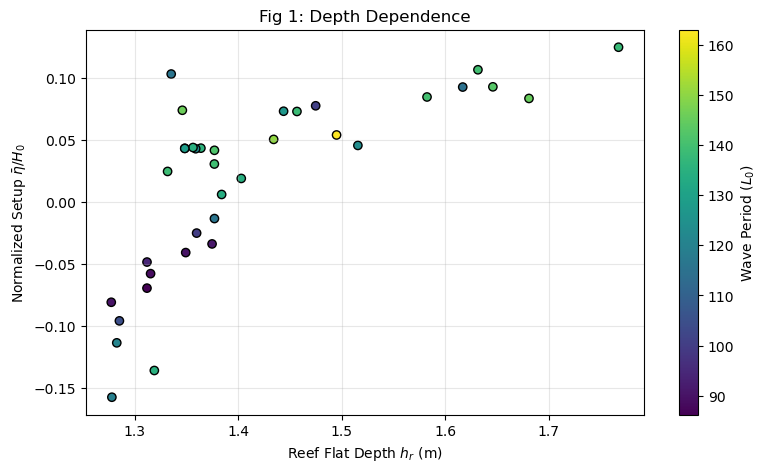

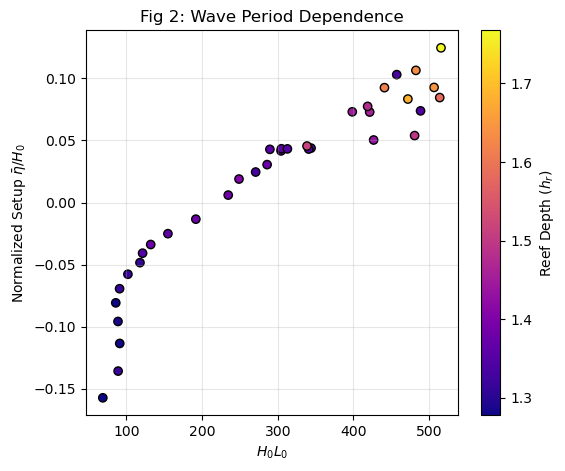

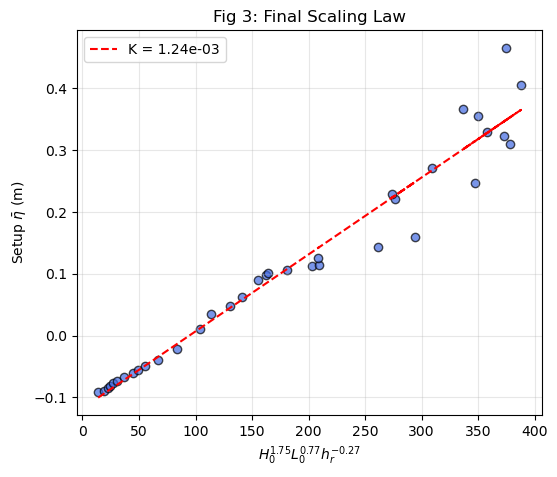

In [ ]:

# --- Fig 2: Wave Period Dependence ---
plt.figure(figsize=(6, 5))
plt.scatter(H0 * L0, y_norm, c=h_r, cmap='plasma', edgecolors='k')
plt.colorbar(label='Reef Depth ($h_r$)')
plt.xlabel('$H_0 L_0$')
plt.ylabel(r'Normalized Setup $\bar{\eta}/H_0$')
plt.title('Fig 2: Wave Period Dependence')
plt.grid(alpha=0.3)
plt.show()

# --- Fig 3: Setup vs Scaling Parameter ---
# Using the exponents found in the scan
scaling_param = (H0**1.75) * (L0**best_l_pow) * (h_r**best_h_pow)

plt.figure(figsize=(6, 5))
plt.scatter(scaling_param, setup, color='royalblue', edgecolors='k', alpha=0.7)

# Add trendline
m, b = np.polyfit(scaling_param, setup, 1)
plt.plot(scaling_param, m*scaling_param + b, 'r--', label=f'K = {m:.2e}')

plt.xlabel(f'$H_0^{{1.75}} L_0^{{{best_l_pow:.2f}}} h_r^{{{best_h_pow:.2f}}}$')
plt.ylabel(r'Setup $\bar{\eta}$ (m)')
plt.title('Fig 3: Final Scaling Law')
plt.legend()
plt.grid(alpha=0.3)
plt.show()